/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 163MB/s] 


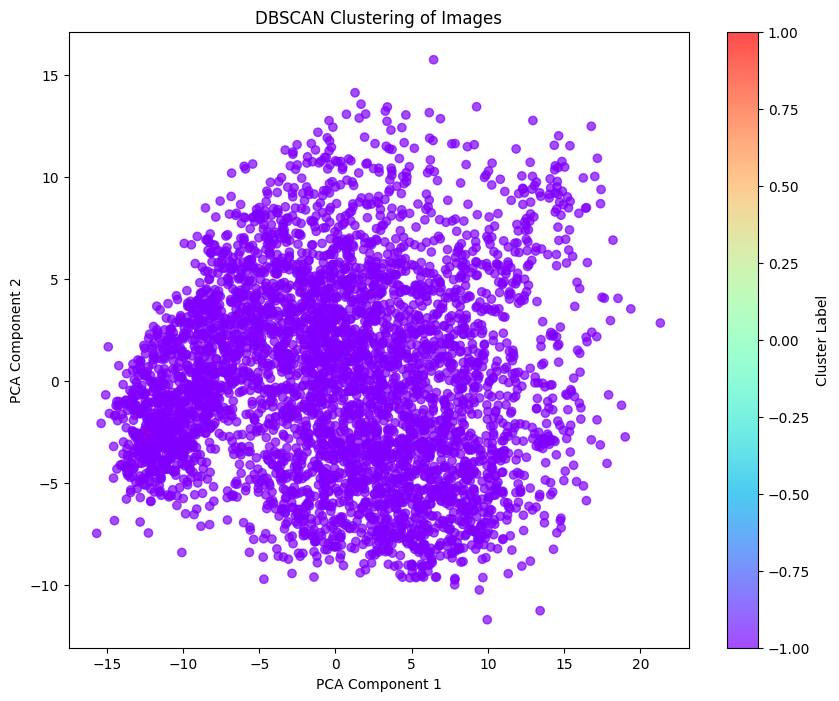

Number of images in each cluster:
Cluster -1: 4386 images
Cluster 0: 2 images
Cluster 1: 2 images


In [5]:
import os
import torch
import torch.nn as nn
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from collections import Counter

# Step 1: Define a Dataset for Flat Directory Structure
class FlatImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = [os.path.join(root_dir, fname) for fname in os.listdir(root_dir) if fname.endswith(('jpg', 'jpeg', 'png'))]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert('RGB')  # Convert to RGB
        if self.transform:
            img = self.transform(img)
        return img, img_path  # Return image and its path

# Step 2: Image Preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images for pre-trained model
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize for ImageNet
])

# Step 3: Load Dataset
dataset_path = '/kaggle/input/clustering/AIDER/normal'  # Replace with your folder containing images
dataset = FlatImageDataset(root_dir=dataset_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

# Step 4: Load Pre-trained Model (ResNet-18) for Feature Extraction
model = models.resnet18(pretrained=True)
model.eval()  # Set the model to evaluation mode
model = nn.Sequential(*list(model.children())[:-1])  # Remove the final classification layer

# Step 5: Extract Features
def extract_features(dataloader, model):
    all_features = []
    all_image_paths = []
    with torch.no_grad():
        for images, image_paths in dataloader:
            features = model(images)
            features = features.view(features.size(0), -1)  # Flatten features
            all_features.append(features)
            all_image_paths.extend(image_paths)
    return torch.cat(all_features, dim=0).numpy(), all_image_paths

features, image_paths = extract_features(dataloader, model)

# Step 6: Standardize Features for Clustering
features = StandardScaler().fit_transform(features)

# Step 7: Apply DBSCAN for Clustering
dbscan = DBSCAN(eps=3.0, min_samples=2)  # Adjust eps and min_samples as needed
labels = dbscan.fit_predict(features)

# Step 8: Visualize Clusters
# Reduce dimensions to 2D using PCA for visualization
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(features)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=labels, cmap='rainbow', alpha=0.7)
plt.title("DBSCAN Clustering of Images")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label='Cluster Label')
plt.show()

# Step 9: Count Images in Each Cluster
cluster_counts = Counter(labels)
print("Number of images in each cluster:")
for cluster_label, count in cluster_counts.items():
    print(f"Cluster {cluster_label}: {count} images")

# Step 10: Save Cluster Results (Optional)
cluster_results = list(zip(image_paths, labels))
with open('cluster_results.txt', 'w') as f:
    for path, label in cluster_results:
        f.write(f"{path}: Cluster {label}\n")
